In [644]:
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rn


from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from PIL import ImageDraw

from time import time
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom
# from scipy.ndimage import imread


from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras import layers
from keras.preprocessing.image import save_img
from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.models import Sequential,Input,Model,load_model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

import pydot
from tensorflow.keras.losses import CategoricalCrossentropy

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn

In [645]:
# MODEL IMAGES PATHS
path_to_vgg16_model_image = "model_images/vgg16.png"

# MODEL WEIGHTS PATHS
# set always net path for weights
path_to_vgg16_model_weights = "./vgg16_weights/vgg16_model_weights"

# CSV LOGS PATHS
path_to_vgg16_csvlog = "./csv_logs/vgg16"

# JSON MODEL PRESENTATION PATHS
vgg16_model_json_path = "./json_models/vgg16.json"

# MODEL PATHS
path_to_vgg16_model = "./models/vgg16"


# Number of epochs hyperparameter
num_of_epochs = 2

In [646]:
RANDOM_STATE = 42

In [647]:
# PATH TO FOOD IMAGES
beans = '../food_images/images/BEANS'
cake = '../food_images/images/CAKE'
candy = '../food_images/images/CANDY'
cereal = '../food_images/images/CEREAL'
chips = '../food_images/images/CHIPS'
chocolate = '../food_images/images/CHOCOLATE'
coffee = '../food_images/images/COFFEE'
corn = '../food_images/images/CORN'
fish = '../food_images/images/FISH'
flour = '../food_images/images/FLOUR'
honey = '../food_images/images/HONEY'
jam = '../food_images/images/JAM'
juice = '../food_images/images/JUICE'
milk = '../food_images/images/MILK'
nuts = '../food_images/images/NUTS'
oil = '../food_images/images/OIL'
pasta = '../food_images/images/PASTA'
rice = '../food_images/images/RICE'
soda = '../food_images/images/SODA'
spices = '../food_images/images/SPICES'
sugar = '../food_images/images/SUGAR'
tea = '../food_images/images/TEA'
tomato_sauce = '../food_images/images/TOMATO_SAUCE'
vinegar = '../food_images/images/VINEGAR'
water = '../food_images/images/WATER'

X = []
Z = []
imgsize = 150

In [648]:
def training_data(label,data_dir):
    for img in tqdm(os.listdir(data_dir)):
        path = os.path.join(data_dir,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(imgsize,imgsize))
        
        X.append(np.array(img))
        Z.append(str(label))

In [649]:
def print_model(model, model_name):
    plot_model(model, to_file = model_name, show_shapes=True, show_layer_names=True)
    SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [650]:
# VGG16 arhitecture
def vgg16_model(img_rows,img_cols):
    base_model = VGG16(include_top=False,
                      input_shape = (img_rows,img_cols,3),
                      weights = 'imagenet',
                      )

    for layer in base_model.layers:
        layer.trainable = False

    for layer in base_model.layers:
        print(layer,layer.trainable)

    model = Sequential()
    model.add(base_model)
#     my layers
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.3))
    model.add(Dense(1000,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(25,activation='softmax'))
    model.summary()
    
    return model

In [651]:
def plot_acc_loss(history, num_of_epochs):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(np.arange(0, num_of_epochs), history.history['loss'], label='train')
    plt.plot(np.arange(0, num_of_epochs), history.history['val_loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.plot(np.arange(0, num_of_epochs), history.history['accuracy'], label='train')
    plt.plot(np.arange(0, num_of_epochs), history.history['val_accuracy'], label='val')
    plt.legend(loc='best')

    plt.show()

In [652]:
def evaluate_model(model,x_test,y_test,classes_names):
    score = model.evaluate(x_test, y_test, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    y_predicted = model.predict(x_test)
    y_predicted_classes = np.argmax(y_predicted, axis = 1)
    y_test_classes = np.argmax(y_test, axis = 1)
    
    conf_mat = confusion_matrix(y_test_classes, y_predicted_classes)
    
    df_cm = pd.DataFrame(conf_mat, index = [i for i in classes_names],
                  columns = [i for i in classes_names])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    
    report = classification_report(y_test_classes, y_predicted_classes)
    print(report)
    
    
    y_predicted_classes.shape, y_test_classes.shape

In [653]:
def write_model_as_json(model, path):
    model_json = model.to_json()
    with open(path,"w") as json_file:
        json_file.write(model_json)

In [654]:
# INITIAL CNN MODEL

# model = Sequential([
#     Input(shape=input_shape),
#     Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
#     MaxPooling2D(pool_size=(2, 2)),
#     Dropout(0.25),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(number_of_classes, activation='softmax')
# ])

# model.summary()
# display(SVG(model_to_dot(model, dpi=65).create(prog='dot', format='svg')))
# model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
# batch_size = 128
# epochs = 12
# history = model.fit(x_train, y_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     verbose=1,
#                     validation_split=0.2)

In [679]:
def test_model():
    model = Sequential([
        Input(shape=(150,150,3)),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(25, activation='softmax')
    ])
    
    model.summary()
    return model

In [656]:
training_data('beans',beans)
training_data('cake',cake)
training_data('candy',candy)
training_data('cereal',cereal)
training_data('chips',chips)
training_data('chocolate',chocolate)
training_data('coffee',coffee)
training_data('corn',corn)
training_data('fish',fish)
training_data('flour',flour)
training_data('honey',honey)
training_data('jam',jam)
training_data('juice',juice)
training_data('milk',milk)
training_data('nuts',nuts)
training_data('oil',oil)
training_data('pasta',pasta)
training_data('rice',rice)
training_data('soda',soda)
training_data('spices',spices)
training_data('sugar',sugar)
training_data('tea',tea)
training_data('tomato sauce',tomato_sauce)
training_data('vinegar',vinegar)
training_data('water',water)

100%|██████████| 262/262 [00:00<00:00, 301.74it/s]


In [657]:
# shape of image
X[0].shape

(150, 150, 3)

In [658]:
# image data format
K.image_data_format()

'channels_last'

In [659]:
len(X),len(Z)

(4947, 4947)

In [660]:
label_encoder= LabelEncoder()
Y = label_encoder.fit_transform(Z)

In [661]:
Y

array([ 0,  0,  0, ..., 24, 24, 24], dtype=int64)

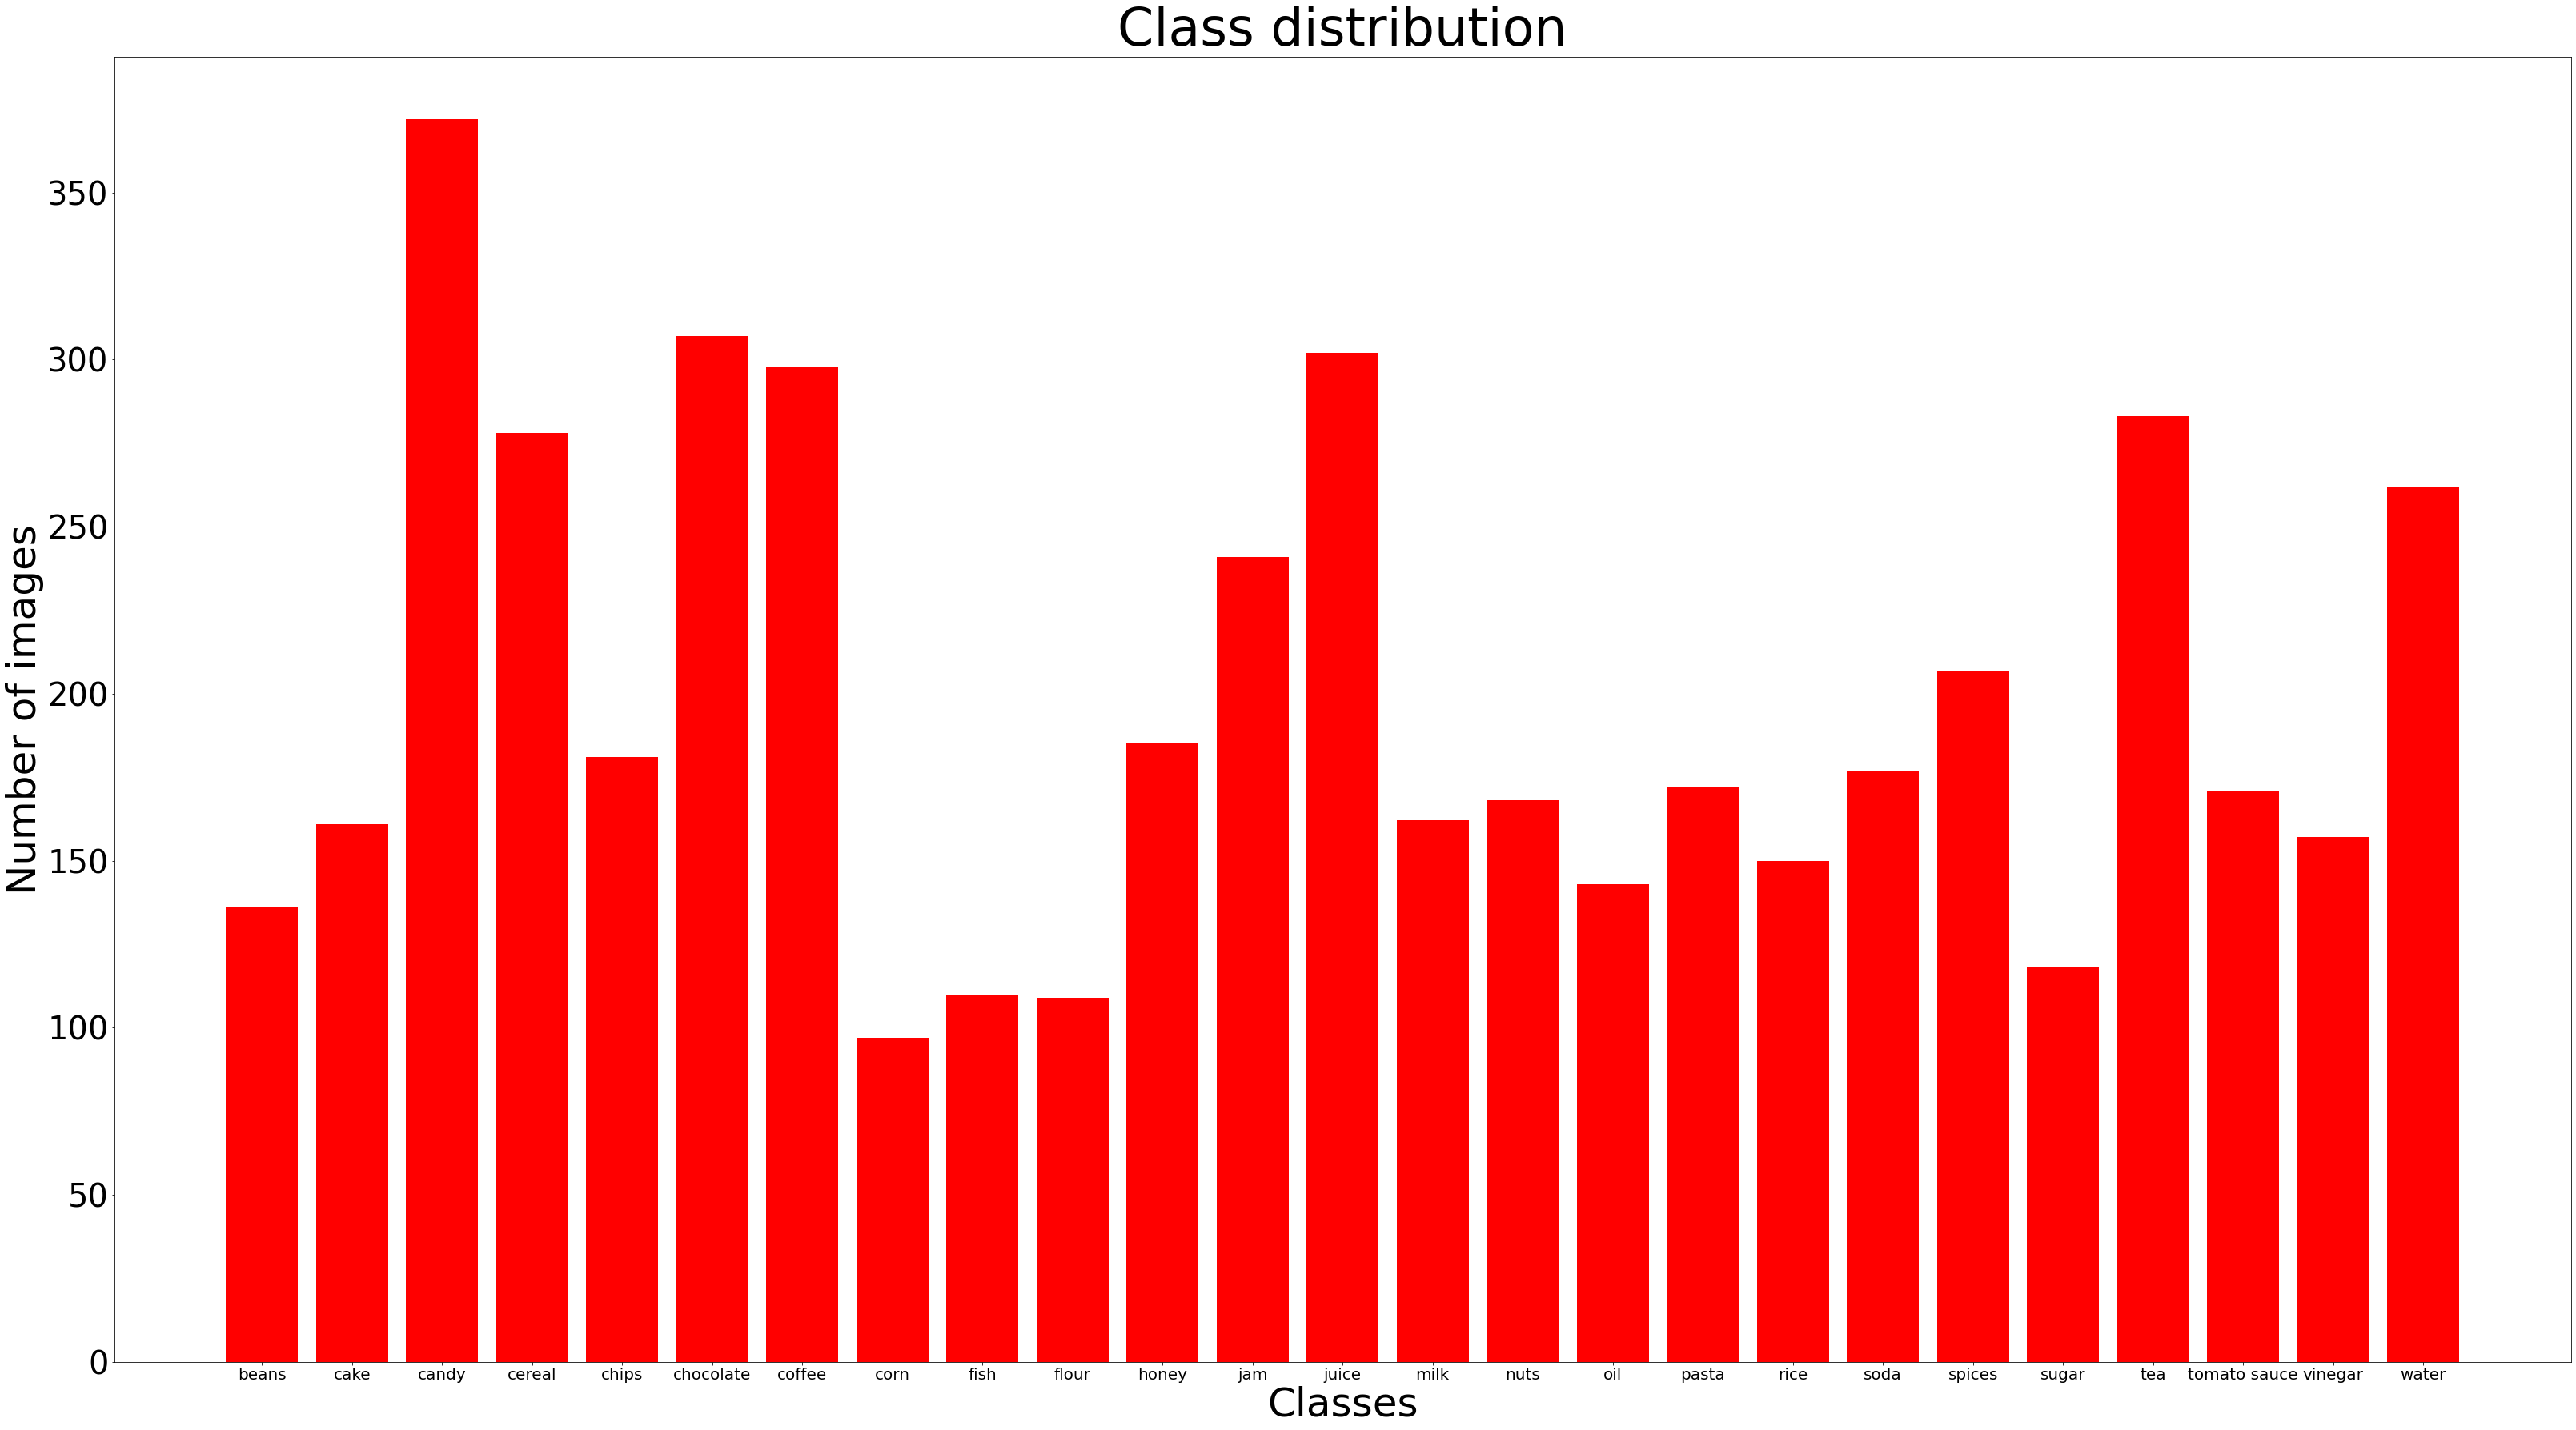

In [662]:
# bar diagram of class distribution
classes_names = ['beans','cake','candy','cereal','chips','chocolate','coffee','corn','fish','flour','honey',
                'jam','juice','milk','nuts','oil','pasta','rice','soda','spices','sugar','tea','tomato sauce','vinegar','water']
plt.figure(figsize=(55,30))
plt.title('Class distribution', fontsize=65)
plt.xlabel('Classes', fontsize=50)
plt.ylabel('Number of images', fontsize=50)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 40)
plt.bar(classes_names,np.bincount(Y), color = 'r')
plt.show()

In [663]:
Y = to_categorical(Y,25)

In [664]:
Y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [665]:
# data scaling
X = np.array(X)
X = X.astype('float32')
X=X/255

In [666]:
X.shape,Y.shape

((4947, 150, 150, 3), (4947, 25))

In [667]:
# train - test - val split
x_train_val, x_test, y_train_val, y_test = train_test_split(X,Y,test_size=0.2,random_state=RANDOM_STATE,stratify=Y)
x_train, x_val, y_train, y_val = train_test_split(x_train_val,y_train_val,test_size=0.2,random_state=RANDOM_STATE,stratify=y_train_val)
x_train.shape,y_train.shape,x_val.shape,y_val.shape,x_test.shape,y_test.shape

((3165, 150, 150, 3),
 (3165, 25),
 (792, 150, 150, 3),
 (792, 25),
 (990, 150, 150, 3),
 (990, 25))

In [668]:
# image data generator
augs_gen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.2,  
        height_shift_range=0.2, 
        horizontal_flip=True,  
        vertical_flip=False) 

augs_gen.fit(x_train)

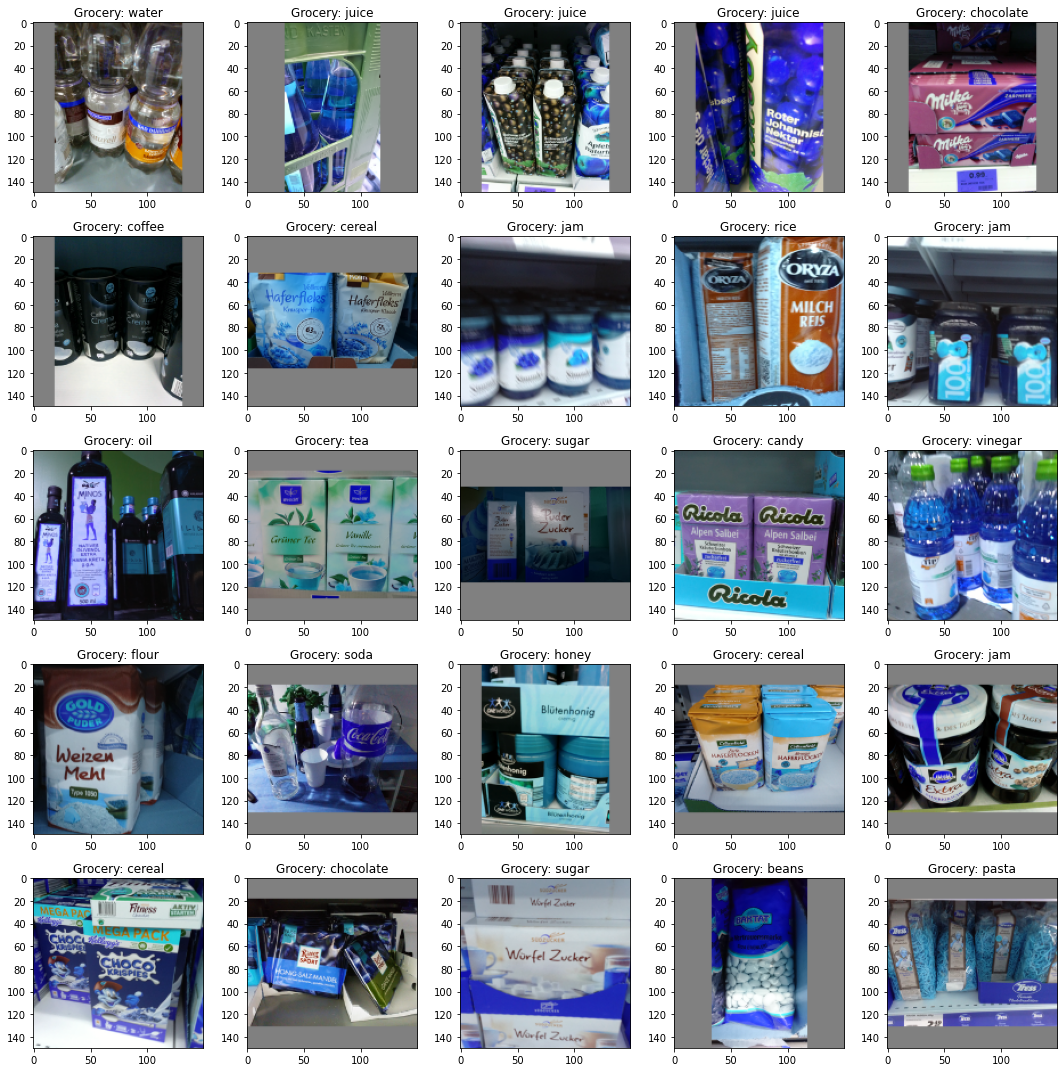

In [476]:
fig,ax=plt.subplots(5,5)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (5):
        k = rn.randint(0, len(Z))
        ax[i,j].imshow(X[k])
        ax[i,j].set_title('Grocery: '+ Z[k])
        
plt.tight_layout()

In [669]:
img_rows = imgsize
img_cols = imgsize
img_rows, img_cols

(150, 150)

In [670]:
# channels_last img format
input_shape = (img_rows, img_cols, 3)
number_of_classes = 25

In [680]:
model = vgg16_model(img_rows, img_cols)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_8 (MaxPooling2 (None, 75, 75, 3)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 16875)             0         
_________________________________________________________________
dense_28 (Dense)             (None, 25)                421900    
Total params: 421,900
Trainable params: 421,900
Non-trainable params: 0
_________________________________________________________________


In [681]:
print_model(model, path_to_vgg16_model_image)
# SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [682]:
checkpoint = ModelCheckpoint(
    filepath=path_to_vgg16_model_weights,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True
)

# TensorBoard provides the visualization
# tensorboard = TensorBoard(
#     log_dir = './vgg16logs',
#     histogram_freq=0,
#     batch_size=16,
#     write_graph=True,
#     write_grads=True,
#     write_images=False,
# )

csvlogger = CSVLogger(
    filename= path_to_vgg16_csvlog,
    separator = ",",
    append = False
)


# Reduce learning rate when a metric has stopped improving
# reduce = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.1,
#     patience=3,
#     verbose=1, 
#     mode='auto'
# )

callbacks = [checkpoint, csvlogger]

In [683]:
model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

history = model.fit(
    augs_gen.flow(x_train, y_train, batch_size = 32),
                    epochs = num_of_epochs,
                    verbose = 1,
                    validation_data  = (x_val, y_val),
                    callbacks=callbacks
                    )

Epoch 1/2
99/99 [==============================] - 16s 160ms/step - loss: 6.2054 - accuracy: 0.0768 - val_loss: 3.7465 - val_accuracy: 0.1136
Epoch 2/2
99/99 [==============================] - 15s 151ms/step - loss: 4.1780 - accuracy: 0.0995 - val_loss: 4.2762 - val_accuracy: 0.0846


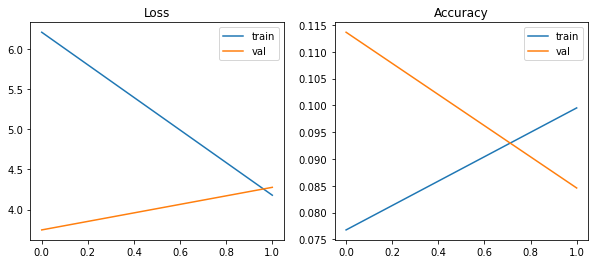

In [684]:
plot_acc_loss(history,num_of_epochs)

In [685]:
# MODEL EVALUATION

31/31 [==============================] - 0s 12ms/step - loss: 4.3284 - accuracy: 0.1061
Test loss: 4.3283915519714355
Test accuracy: 0.10606060922145844


C:\Users\Milos\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Milos\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Milos\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.10      0.37      0.16        27
           1       0.00      0.00      0.00        32
           2       0.43      0.29      0.35        75
           3       0.00      0.00      0.00        56
           4       0.12      0.22      0.16        36
           5       0.14      0.15      0.14        62
           6       0.00      0.00      0.00        60
           7       0.00      0.00      0.00        19
           8       0.00      0.00      0.00        22
           9       0.04      0.59      0.07        22
          10       0.50      0.11      0.18        37
          11       0.20      0.17      0.18        48
          12       0.00      0.00      0.00        61
          13       0.00      0.00      0.00        32
          14       0.00      0.00      0.00        34
          15       0.00      0.00      0.00        29
          16       0.10      0.21      0.13        34
          17       0.50    

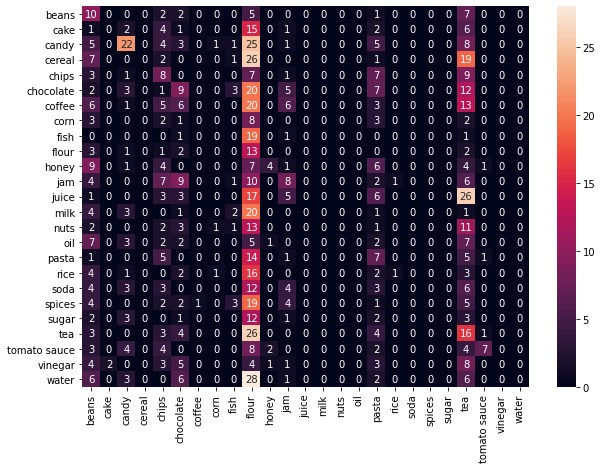

In [686]:
evaluate_model(model,x_test,y_test,classes_names)


In [687]:
# take weights with max acc
# ret = model.load_weights(path_to_vgg1_model_weights)

In [688]:
# SAVING MODEL

In [689]:
write_model_as_json(model,vgg16_model_json_path)

In [690]:
model.save(path_to_vgg16_model)

INFO:tensorflow:Assets written to: ./models/vgg16\assets


In [588]:
# model1 = load_model(path_to_vgg16_model)

In [589]:
# evaluate_model(model1,x_test,y_test,classes_names)